In [47]:
import torch
import pickle
import numpy as np
from sklearn.metrics import matthews_corrcoef, confusion_matrix

from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification, BertForTokenClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count
from util.tools  import *
from util import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [48]:
DATA_DIR = "data/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'Relation Extraction'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 10
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1


CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [49]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [50]:
tokenizer = BertTokenizer.from_pretrained(OUTPUT_DIR + 'vocab.txt', do_lower_case=False)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file outputs/Relation Extraction/vocab.txt


In [51]:
processor = MultiClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
eval_examples_len = len(eval_examples)

In [52]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
num_labels

42

In [53]:
eval_examples_for_processing = [(example,  MAX_SEQ_LENGTH, tokenizer) for example in eval_examples]

In [54]:
process_count = cpu_count() - 1
with Pool(process_count) as p:
    eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

<ipython-input-54-b1a351825a56>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))


In [55]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([int(f.label_id) for f in eval_features], dtype=torch.long)

In [56]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [57]:
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + BERT_MODEL, cache_dir=CACHE_DIR, num_labels=len(label_list))
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)
path = OUTPUT_DIR +  'pytorch_model.bin'
model.load_state_dict(torch.load(path))
model.eval()

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.modeling:extracting archive file cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c to temp dir C:\Users\pnarsina\AppData\Local\Temp\2\tmppzh5bvs3
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_pretrained_bert.modeling:Weights of BertForSequenceClassification not initial

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [58]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [59]:

model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    # create eval loss and other metric required by the task
    loss_fct = CrossEntropyLoss()
    tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()

    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)



<ipython-input-59-adeaaf365af2>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):


In [60]:
eval_loss
len(preds), len(all_label_ids)

(15509, 15509)

In [61]:
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    cm = confusion_matrix(labels, preds)
    return {
        "task": task_name,
        "mcc": mcc,
         "cm": cm
    }


def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [62]:
import json
CONFIG_FOLDER = 'config/'
id_label_file = 'id_2_label.json'
with open(CONFIG_FOLDER + id_label_file) as infile:
    id2label = json.load(infile)

In [63]:
preds_labels = [id2label[str(p)] for p in preds]
all_labels =  [id2label[str(l)] for l in all_label_ids.numpy()]
mcc = matthews_corrcoef(all_labels, preds_labels)

print('Correlation Coefficient is ', mcc)

mismatches = []
all_rels = []
for row in range(len(all_labels)):
    all_rels.append([all_labels[row], preds_labels[row]])
    if preds_labels[row] != all_labels[row]:
        mismatches.append([all_labels[row], preds_labels[row]])
        

        

Correlation Coefficient is  0.6327045561071952


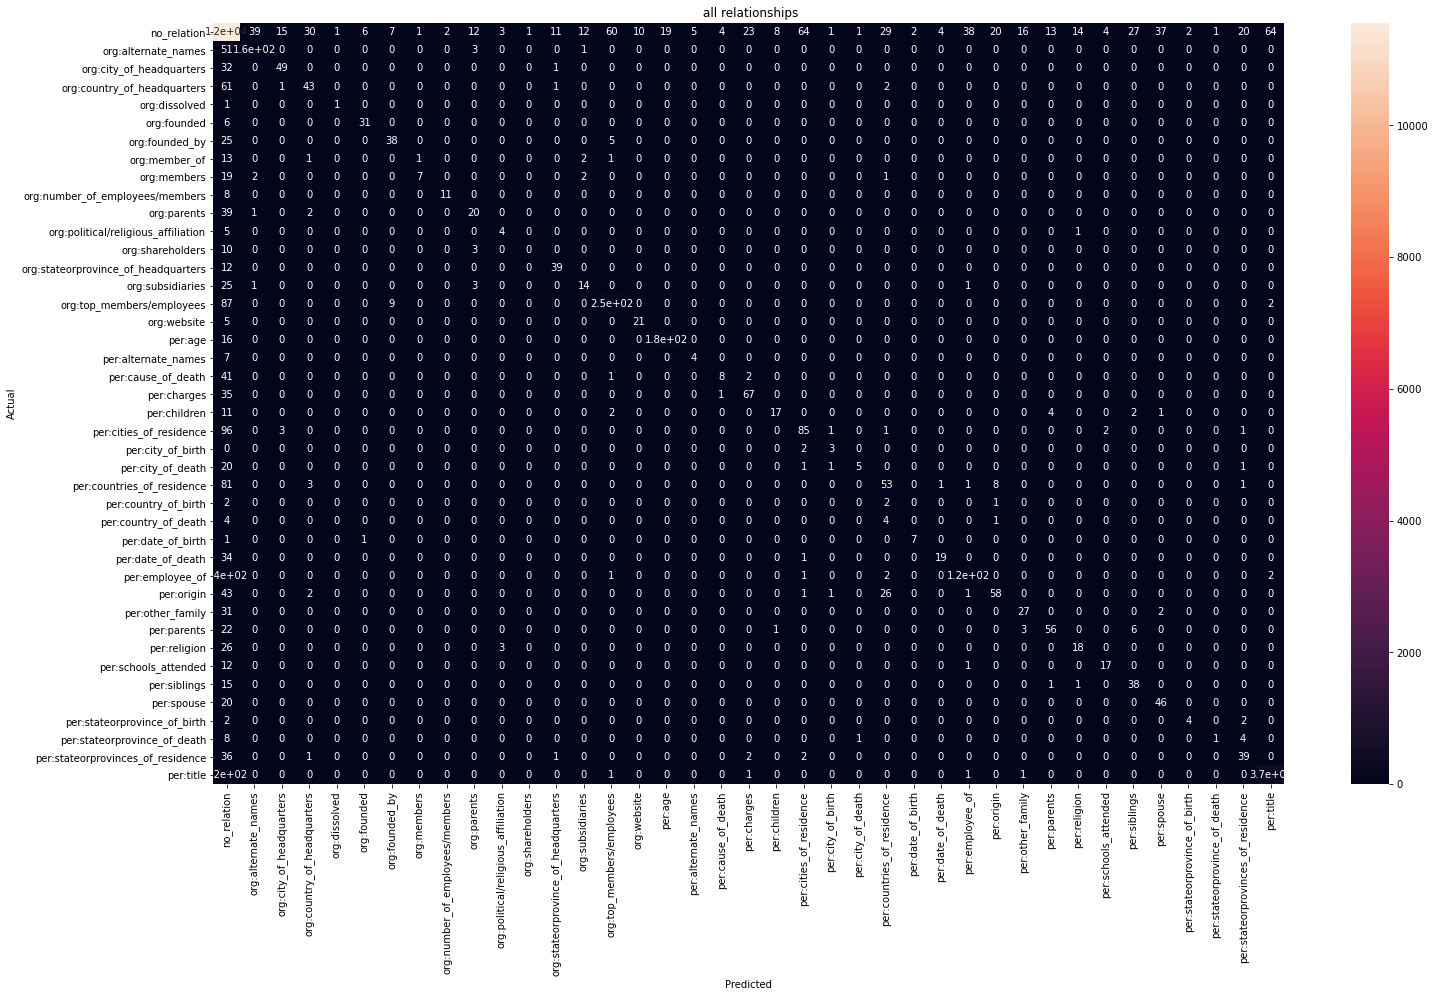

In [64]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(all_rels, columns = ['labels', 'predicted'])
# df.head(10)
plt.figure(figsize=(24,14))
plt.title(" all relationships")
confusion_matrix = pd.crosstab(df['labels'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

plt.show()


In [65]:
df

,labels,predicted
0,no_relation,per:employee_of
1,no_relation,no_relation
2,no_relation,no_relation
3,no_relation,no_relation
4,no_relation,no_relation
...,...,...
15504,no_relation,no_relation
15505,per:age,per:age
15506,no_relation,no_relation
15507,no_relation,no_relation


In [66]:
from sklearn import metrics
metrics.f1_score(df["labels"], df["predicted"], average='micro')

0.8700109613772649